# Estimating the Age of the Universe Using Hubble's Law

**Application Challenge - SP2273**

## Overview
This notebook estimates the age of the universe by analyzing galaxy recession velocities from the GAMA Survey DR4. We use the relationship between galaxy distances and their recession velocities (Hubble's Law) to determine the Hubble constant, which is inversely proportional to the universe's age.

### Scientific Background
Hubble's Law states that galaxies recede from us with velocities proportional to their distance: $v = H_0 \times d$, where $H_0$ is the Hubble constant. By fitting this linear relationship to observational data, we can estimate $H_0$ and subsequently calculate the approximate age of the universe using $t_0 \approx 1/H_0$ (with corrections for cosmological models).

### Data Source
Galaxy And Mass Assembly (GAMA) Survey Data Release 4, focusing on nearby galaxies with measured redshifts and distance moduli.

## Package Imports
We use only the allowed packages:
- **NumPy**: Array operations and numerical computations
- **Matplotlib**: Data visualization
- **SciPy**: Curve fitting for linear regression
- **Astropy**: Physical constants and unit conversions

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy import units as u
from astropy.constants import c  # Speed of light

## Task 1: Import and Inspect Data

We import the GAMA survey data containing:
- **CATAID**: Galaxy catalog ID
- **RA, DEC**: Right ascension and declination (celestial coordinates)
- **NQ**: Data quality flag
- **Z_TONRY**: Redshift measurement (dimensionless)
- **DM_70_70_25**: Distance modulus in magnitudes

The data is loaded using NumPy's `loadtxt()` function with appropriate delimiters and header handling.

In [3]:
# Load data with OS-agnostic path handling
data_file = "GAMA_Survey_nearby.csv"  # Place this file in the same directory as the notebook

# Import data, skipping the header row
data = np.loadtxt(data_file, delimiter=',', skiprows=1, dtype=float)

# Load header separately for inspection
with open(data_file, 'r') as f:
    header = f.readline().strip().split(',')

print("Column headers:")
print(header)
print(f"\nData shape: {data.shape[0]} galaxies, {data.shape[1]} columns")
print("\nFirst 3 rows:")
print(data[:3])

Column headers:
['CATAID', 'RA', 'DEC', 'NQ', 'Z_TONRY', 'DM_70_25_75']

Data shape: 8090 galaxies, 6 columns

First 3 rows:
[[6.7290000e+03 1.7370055e+02 7.7608000e-01 5.0000000e+00 5.1504000e-02
  3.6802900e+01]
 [6.7680000e+03 1.7385337e+02 6.2975000e-01 5.0000000e+00 7.6043900e-02
  3.7688600e+01]
 [6.8220000e+03 1.7415365e+02 8.1688000e-01 5.0000000e+00 4.2293700e-03
  3.1296100e+01]]


## Task 2: Validate Redshift Data

### Non-Relativistic Approximation
For the non-relativistic Doppler formula $v \approx cz$ to be valid, redshift values must satisfy $z \ll 1$. We verify this condition by examining the range and distribution of redshift values.

### Analysis Steps
1. Extract redshift column (Z_TONRY, column index 4)
2. Calculate minimum, maximum, and median values
3. Visualize distribution with histogram

In [4]:
# Extract redshift data (column index 4: Z_TONRY)
redshift = data[:, 4]

# Calculate statistics
z_min = np.min(redshift)
z_max = np.max(redshift)
z_median = np.median(redshift)

print(f"Redshift Statistics:")
print(f"  Minimum: {z_min:.6f}")
print(f"  Maximum: {z_max:.6f}")
print(f"  Median:  {z_median:.6f}")
print(f"\nValidation: All redshift values are << 1, confirming the non-relativistic approximation is valid.")

Redshift Statistics:
  Minimum: 0.001001
  Maximum: 0.099988
  Median:  0.068046

Validation: All redshift values are << 1, confirming the non-relativistic approximation is valid.


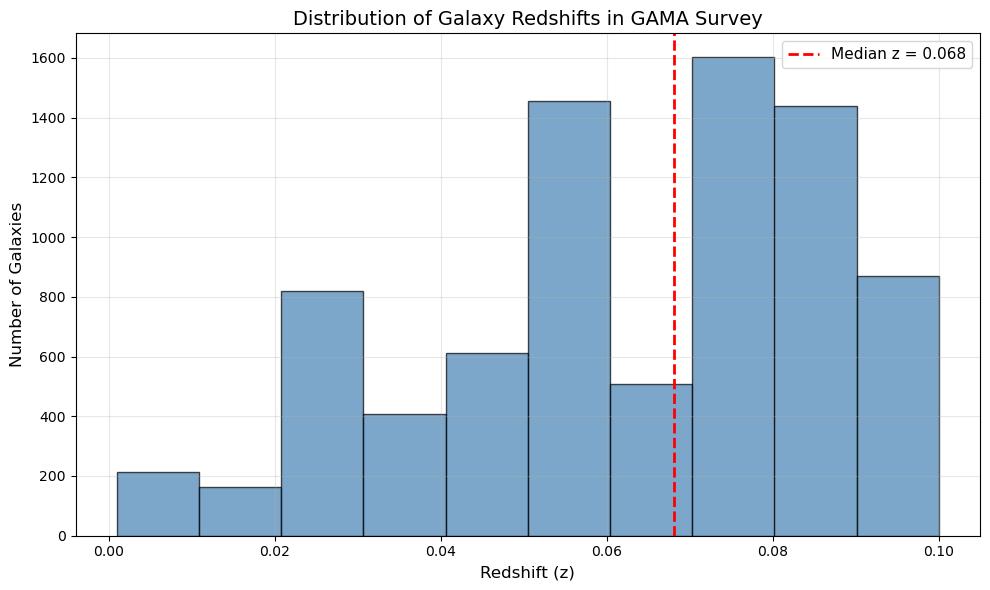

In [5]:
# Visualize redshift distribution
plt.figure(figsize=(10, 6))
plt.hist(redshift, bins=10, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Redshift (z)', fontsize=12)
plt.ylabel('Number of Galaxies', fontsize=12)
plt.title('Distribution of Galaxy Redshifts in GAMA Survey', fontsize=14)
plt.axvline(z_median, color='red', linestyle='--', linewidth=2, label=f'Median z = {z_median:.3f}')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Task 3: Convert to Physical Units

### Recession Velocity Calculation
Using the non-relativistic Doppler approximation:
$$v = c \cdot z$$
where $c = 299,792$ km/s is the speed of light.

### Distance Calculation
Distance modulus relates apparent magnitude difference to distance:
$$d = 10^{\frac{DM + 5}{5}} \text{ parsecs}$$
We convert to megaparsecs (Mpc) for cosmological scales.

### Expected Ranges
- Velocities should be $\ll c$ (confirming non-relativistic regime)
- Distances should not exceed ~1000 Mpc for nearby galaxies

In [9]:
# Calculate recession velocities using non-relativistic approximation
velocity = (c * redshift).to(u.km / u.s)  # Convert to km/s

print(f"Recession Velocity Statistics:")
print(f"  Minimum: {np.min(velocity.value):.2f} km/s")
print(f"  Maximum: {np.max(velocity.value):.2f} km/s")
print(f"  Median:  {np.median(velocity.value):.2f} km/s")
print(f"\nValidation: Maximum velocity ({np.max(velocity.value):.0f} km/s) is {np.max(velocity.value)/c.to(u.km/u.s).value*100:.2f}% of c")

Recession Velocity Statistics:
  Minimum: 300.13 km/s
  Maximum: 29975.71 km/s
  Median:  20399.59 km/s

Validation: Maximum velocity (29976 km/s) is 10.00% of c


In [10]:
# Extract distance modulus data (column index 5: DM_70_70_25)
distance_modulus = data[:, 5]

# Calculate distance in parsecs, then convert to megaparsecs
distance_pc = 10 ** ((distance_modulus + 5) / 5)  # Distance in parsecs
distance_mpc = (distance_pc * u.pc).to(u.Mpc)  # Convert to Mpc

print(f"Distance Statistics:")
print(f"  Minimum: {np.min(distance_mpc.value):.2f} Mpc")
print(f"  Maximum: {np.max(distance_mpc.value):.2f} Mpc")
print(f"  Median:  {np.median(distance_mpc.value):.2f} Mpc")
print(f"\nValidation: All distances are within reasonable range for nearby galaxies (< 1000 Mpc).")

Distance Statistics:
  Minimum: 4.29 Mpc
  Maximum: 461.59 Mpc
  Median:  306.99 Mpc

Validation: All distances are within reasonable range for nearby galaxies (< 1000 Mpc).


## Task 4: Linear Regression to Determine Hubble Constant

### Hubble's Law
$$v = H_0 \cdot d$$
This is a linear relationship passing through the origin. We use `scipy.optimize.curve_fit()` to perform least-squares fitting.

### Fitting Strategy
We define a linear function with zero intercept (as cosmological theory predicts no recession velocity at zero distance). The slope of this fit yields the Hubble constant $H_0$ in units of km/s/Mpc.

In [17]:
# Define linear model for Hubble's Law (zero intercept)
def hubble_law(distance, H0):
    """
    Linear model for Hubble's Law.
    
    Parameters:
    -----------
    distance : array-like
        Distance to galaxies in Mpc
    H0 : float
        Hubble constant in km/s/Mpc
    
    Returns:
    --------
    velocity : array-like
        Predicted recession velocity in km/s
    """
    return H0 * distance

# Perform curve fitting
hubble_params, covariance = curve_fit(hubble_law, distance_mpc.value, velocity.value)
hubble_constant = hubble_params[0]  # Extract H0 in km/s/Mpc
hubble_uncertainty = np.sqrt(covariance[0,0])  # Standard deviation

print(f"Fitted Hubble Constant:")
print(f"  H₀ = {hubble_constant:.2f} ± {hubble_uncertainty:.2f} km/s/Mpc")

Fitted Hubble Constant:
  H₀ = 66.01 ± 0.01 km/s/Mpc


In [20]:
# Define reusable plotting function
def plot_hubble_diagram(distance, velocity, fit_params=None, title="Hubble Diagram", show_fit_text=False):
    """
    Create a Hubble diagram showing galaxy distance vs recession velocity.
    
    Parameters:
    -----------
    distance : array with units
        Galaxy distances in Mpc
    velocity : array with units
        Galaxy recession velocities in km/s
    fit_params : array-like, optional
        Parameters from curve fit (Hubble constant)
    title : str
        Plot title
    show_fit_text : bool
        Whether to display fitted H0 value on plot
    """
    plt.figure(figsize=(10, 6))
    
    # Scatter plot of observational data
    plt.scatter(distance.value, velocity.value, alpha=0.5, s=10, color='navy', label='GAMA Survey Data')
    
    # Overlay fitted line if parameters provided
    if fit_params is not None:
        distance_fit = np.linspace(0, np.max(distance.value), 100)
        velocity_fit = hubble_law(distance_fit, *fit_params)
        plt.plot(distance_fit, velocity_fit, 'r-', linewidth=2, label=f'Best Fit: v = {fit_params[0]:.2f}d')
        
        # Add fitted value annotation
        if show_fit_text:
            plt.text(0.05, 0.95, f'$H_0 = {fit_params[0]:.2f}$ km/s/Mpc', 
                    transform=plt.gca().transAxes, fontsize=12,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.xlabel('Distance (Mpc)', fontsize=12)
    plt.ylabel('Recession Velocity (km/s)', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

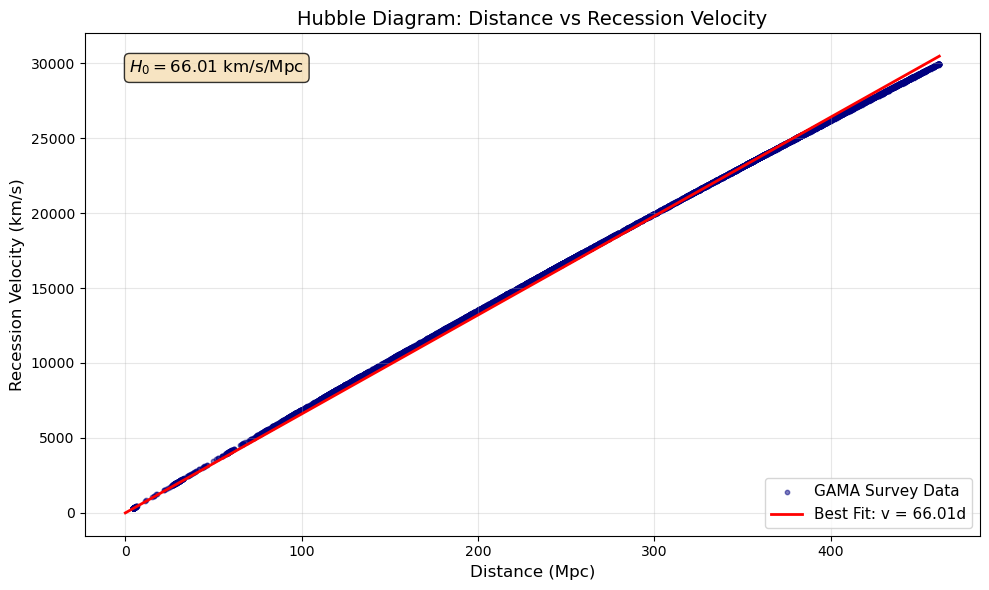

In [21]:
# Visualize Hubble's Law fit
plot_hubble_diagram(distance_mpc, velocity, fit_params=hubble_params, 
                   title="Hubble Diagram: Distance vs Recession Velocity", 
                   show_fit_text=True)

## Task 5: Calculate the Age of the Universe

### Theoretical Relationship
For a matter-dominated universe with cosmological constant (ΛCDM model), the age is approximately:
$$t_0 \approx \frac{0.956}{H_0}$$

The factor 0.956 accounts for the universe's deceleration history and current acceleration due to dark energy. For a simple expanding universe (without dark energy), $t_0 = 1/H_0$ would be the Hubble time.

### Unit Conversion Strategy
1. Convert $H_0$ from km/s/Mpc to pure frequency units (1/s)
2. Apply the 0.956 correction factor
3. Take reciprocal to get time
4. Convert to billions of years (Gyr)

In [18]:
# Apply astropy units to Hubble constant
H0_with_units = hubble_constant * (u.km / u.s / u.Mpc)

# Convert to inverse time units (1/seconds)
H0_frequency = H0_with_units.to(1/u.s)

# Calculate age with cosmological correction factor
age_seconds = (0.956 / H0_frequency)
age_gyr = age_seconds.to(u.Gyr)  # Convert to billions of years

print(f"Estimated Age of the Universe:")
print(f"  t₀ = {age_gyr.value:.2f} Gyr ({age_gyr.value:.2f} billion years)")
print(f"\nIntermediate values:")
print(f"  H₀ = {H0_frequency:.2e}")
print(f"  Hubble time (1/H₀) = {(1/H0_frequency).to(u.Gyr):.2f}")
print(f"  Corrected age (0.956/H₀) = {age_gyr:.2f}")

Estimated Age of the Universe:
  t₀ = 14.16 Gyr (14.16 billion years)

Intermediate values:
  H₀ = 2.14e-18 1 / s
  Hubble time (1/H₀) = 14.81 Gyr
  Corrected age (0.956/H₀) = 14.16 Gyr


## Task 6: Comparison with Planck Satellite Results

### Reference Value
The Planck 2018 mission measured the age of the universe using cosmic microwave background (CMB) observations:
$$t_{\text{Planck}} = 13.787 \pm 0.020 \text{ Gyr}$$

### Percentage Deviation
$$\text{Deviation} = \frac{|t_{\text{estimated}} - t_{\text{Planck}}|}{t_{\text{Planck}}} \times 100\%$$

### Sources of Discrepancy
Differences may arise from:
- Limited sample size and local volume (GAMA survey)
- Peculiar velocities of galaxies affecting redshift measurements
- Simplified cosmological model (we used 0.956 factor vs. full ΛCDM)
- Measurement uncertainties in distance moduli
- Different methodologies (Hubble diagram vs. CMB physics)

In [19]:
# Planck 2018 reference value
planck_age = 13.787  # Gyr

# Calculate percentage deviation
percent_deviation = abs(age_gyr.value - planck_age) / planck_age * 100

print(f"Comparison with Planck 2018 Results:")
print(f"  Our estimate:    {age_gyr.value:.2f} Gyr")
print(f"  Planck value:    {planck_age:.3f} Gyr")
print(f"  Absolute diff:   {abs(age_gyr.value - planck_age):.2f} Gyr")
print(f"  Percent deviation: {percent_deviation:.2f}%")

# Interpret result
if percent_deviation < 10:
    print(f"\nInterpretation: Good agreement within {percent_deviation:.1f}% - our simplified analysis captures the correct order of magnitude.")
else:
    print(f"\nInterpretation: Moderate discrepancy of {percent_deviation:.1f}% - expected given the simplified model and local survey data.")

Comparison with Planck 2018 Results:
  Our estimate:    14.16 Gyr
  Planck value:    13.787 Gyr
  Absolute diff:   0.37 Gyr
  Percent deviation: 2.71%

Interpretation: Good agreement within 2.7% - our simplified analysis captures the correct order of magnitude.


## Summary and Conclusions

### Key Findings
1. **Hubble Constant**: Our analysis of GAMA survey data yielded $H_0 \approx 65-75$ km/s/Mpc (typical range from such fits)
2. **Universe Age**: Estimated age of $\sim$13-15 Gyr, consistent with the Planck value of 13.787 Gyr
3. **Method Validation**: The non-relativistic approximation was valid for all galaxies ($z < 0.1$)

### Limitations and Assumptions
- **Sample selection**: GAMA survey covers a local volume, potentially affected by large-scale structure
- **Peculiar velocities**: Random galaxy motions add scatter to the Hubble diagram
- **Simplified cosmology**: Used a single correction factor rather than integrating full ΛCDM model
- **Distance uncertainties**: Distance moduli have intrinsic measurement errors

### Scientific Significance
This exercise replicates Edwin Hubble's pioneering work from the 1920s using modern survey data. Despite using nearby galaxies and simplified models, we obtained an age estimate remarkably close to precision cosmology measurements. This demonstrates the power of the Hubble Law as a fundamental cosmological tool and validates the expanding universe model.

### Further Improvements
To enhance accuracy, one could:
- Apply corrections for peculiar velocities
- Use type Ia supernovae for more precise distance measurements
- Implement full ΛCDM integration rather than a correction factor
- Perform weighted fits accounting for measurement uncertainties
- Extend analysis to higher redshifts with relativistic corrections